In [93]:
from analysis import *

%matplotlib inline

# Set style for all plots
sns.set_style("whitegrid")
plt.style.use('seaborn')


/var/folders/13/81m8_c8s5x3dwyxpg6hc69nw0000gn/T/ipykernel_85255/1484485703.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 1. parallelization speedup ~ throughput (episodes/fixed time budget) ~ playing strength (win rate, Elo)

<Figure size 1500x1000 with 0 Axes>

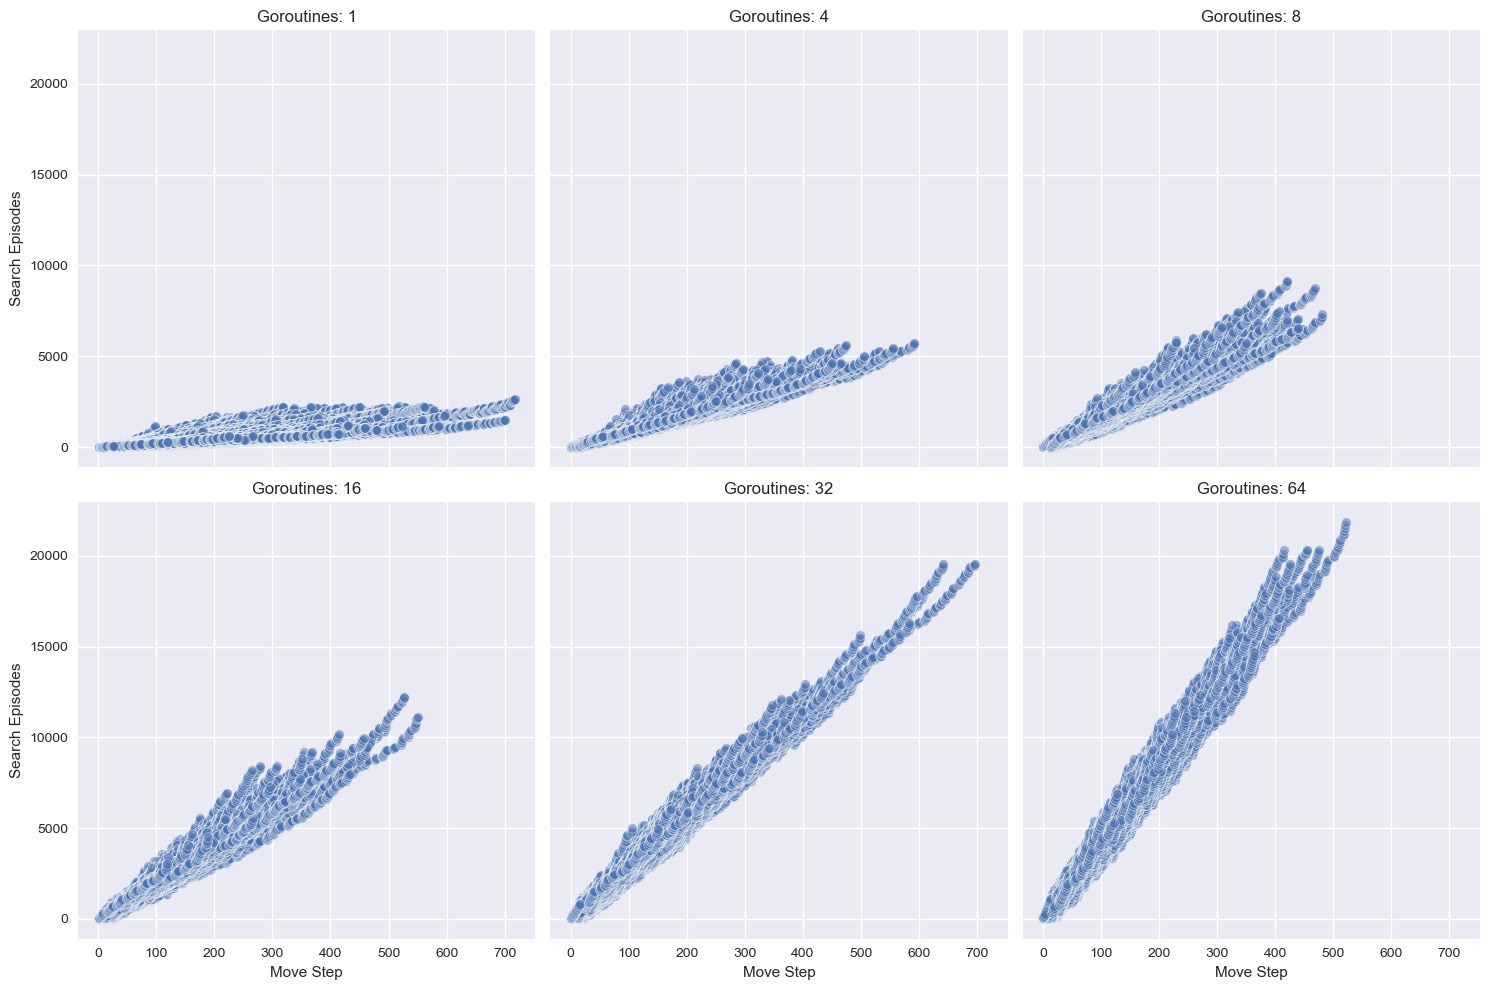

In [94]:
# Load experiment data
# TODO: use same experiment setup as strength experiment (diff concurrency levels parallel agents vs baseline)
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/parallelism")

# Generate plots
# TODO: smaller dot
plt = plot_episodes_by_step(move_records, agent_configs, output_dir)
plt.show()

- environment: 8-core CPU (4 performance cores + 4 efficiency cores)
- concurrency level increase (x4) -> episodes increase both earlier in game and in volume
- full playouts (no cutoff) > faster playouts/more episodes as game progresses/deeper into game

<Figure size 1500x1000 with 0 Axes>

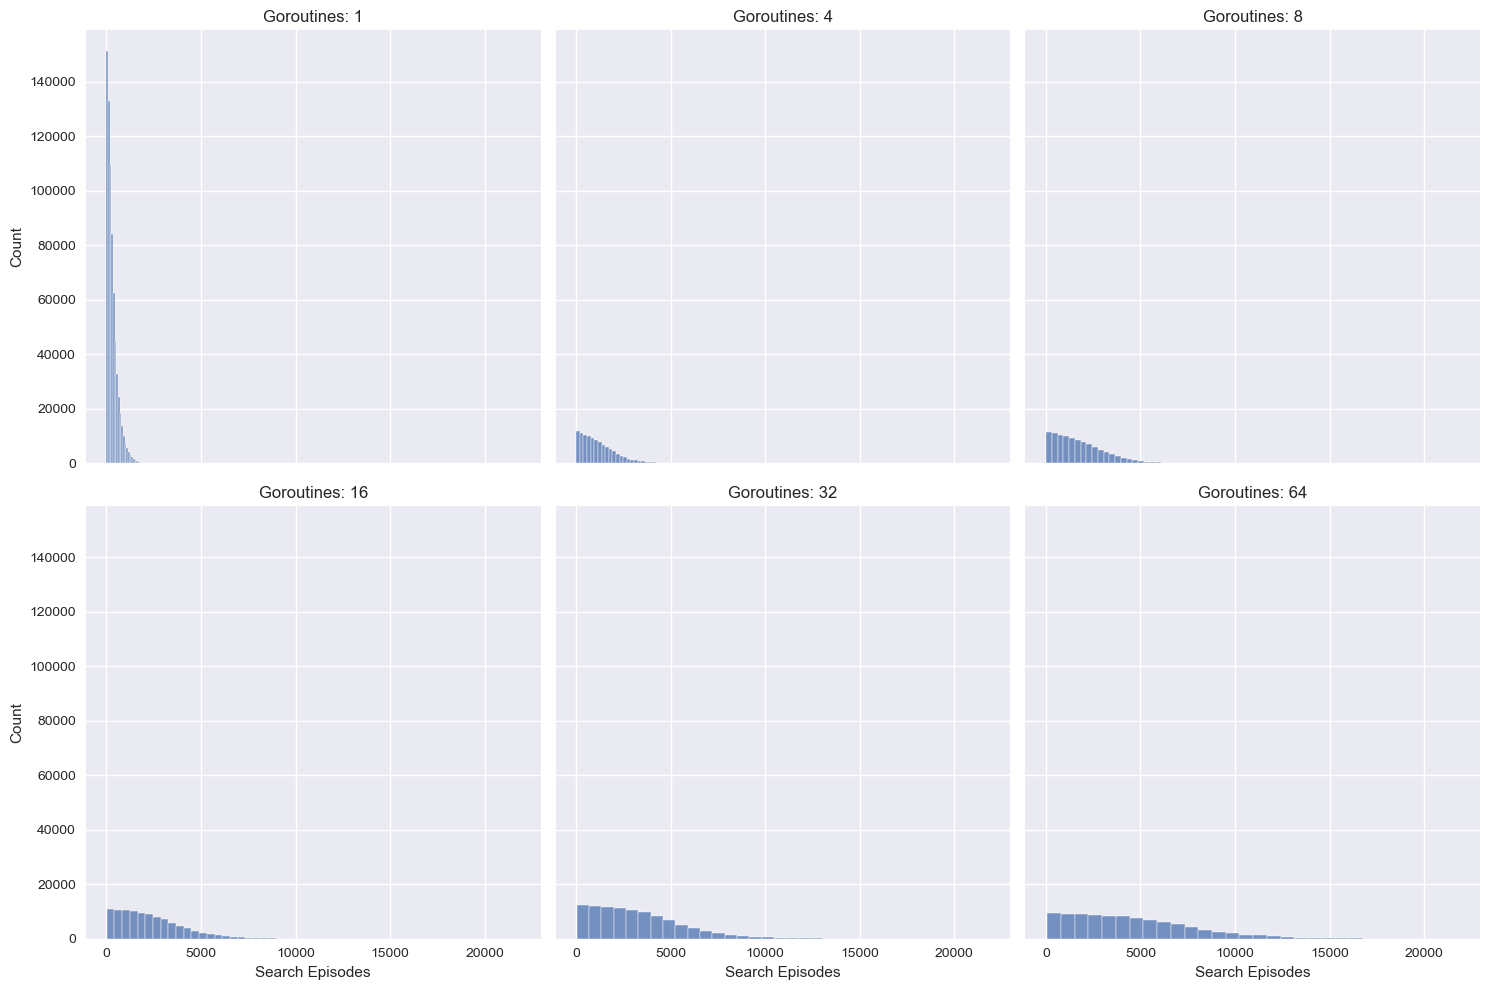

In [95]:
plt = plot_episodes_histogram(move_records, agent_configs, output_dir)
plt.show()

- all power law distribution (most searches have few episodes) > use box plot
- concurrency level increase -> more searchers with more episodes 

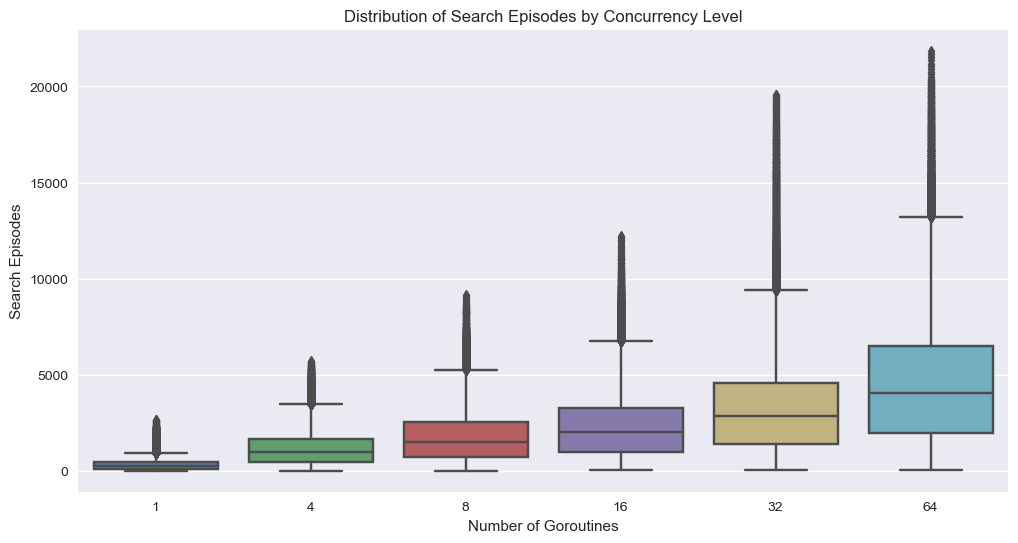

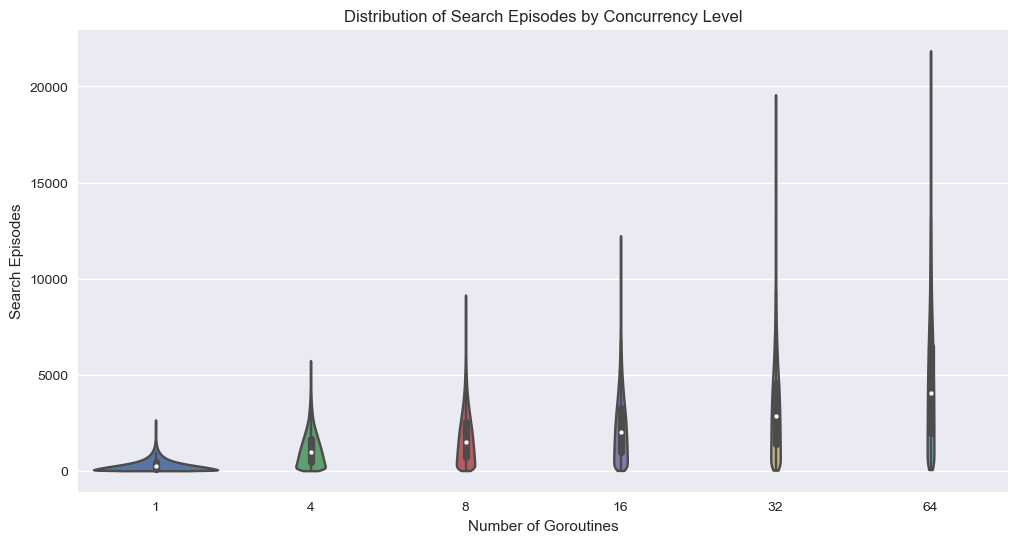


Summary Statistics by Concurrency Level:
                   mean          std  min    max
goroutines                                      
1            313.766759   286.880083    1   2648
4           1149.422724   880.230799    4   5733
8           1762.162437  1310.089779    9   9146
16          2307.144725  1681.263934   16  12231
32          3255.650450  2418.150552   32  19574
64          4541.673583  3219.326308   64  21860


In [96]:
plt = plot_episodes_boxplot(move_records, agent_configs, output_dir)
plt.show()

plt = plot_episodes_violin(move_records, agent_configs, output_dir)
plt.show()

# Print summary statistics
print("\nSummary Statistics by Concurrency Level:")
summary = move_records.groupby('goroutines')['episodes'].agg(['mean', 'std', 'min', 'max'])
print(summary)

- higher concurrency level -> more episodes
- not much diff between 4 and 8: why?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


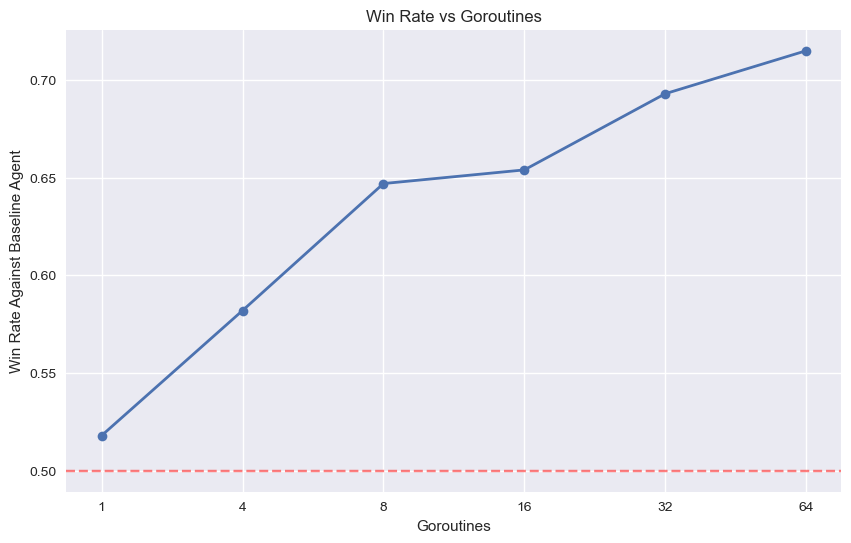


Win Rates vs Baseline Agent:
   agent2  games  wins  win_rate  id  goroutines duration  episodes  cutoff  \
0       1   1000   518     0.518   1           1      8ms         0       0   
1       2   1000   582     0.582   2           4      8ms         0       0   
2       3   1000   647     0.647   3           8      8ms         0       0   
3       4   1000   654     0.654   4          16      8ms         0       0   
4       5   1000   693     0.693   5          32      8ms         0       0   
5       6   1000   715     0.715   6          64      8ms         0       0   

  evaluation  
0          .  
1          .  
2          .  
3          .  
4          .  
5          .  


In [97]:
# Calculate and plot win rates
win_rates = calculate_win_rates(game_records, agent_configs)
# TODO: write number of games played
plt = plot_win_rates(win_rates, param_col="goroutines", output_dir=output_dir)
plt.show()

print("\nWin Rates vs Baseline Agent:")
print(win_rates)


- baseline agent vs 1-goroutine agent win rate not 0.5??
- should see steady climb in win rate as concurrency level increases
- win rate reflects relative playing strength against baseline agent 
- elo rating reflects relative playing strength against all other agents 
=> should show similar trend: higher concurrency > more episodes per time budget > greater playing strength > higher win rate & Elo rating

- don't show baseline agent rating: more games played > drags rating down to below 1-goroutine agent's (despite 0.5 win rate)
- should reflect similar trend as win rate

In [98]:
# TODO: to potentially explain irregularities in results:
# TODO: plot # of full playouts out of (vs) # of episodes per step across per matchup games, then analyze and explain 
# TODO: plot # of tree resets per step across per matchup games, then analyze and explain


# 2. cutoff depth ~ throughput (episodes/time budget) ~ playing strength (win rate)

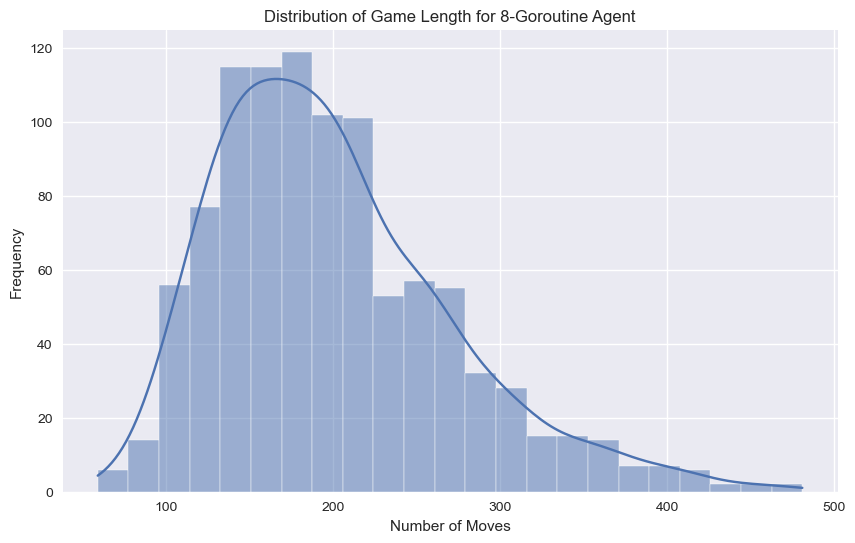

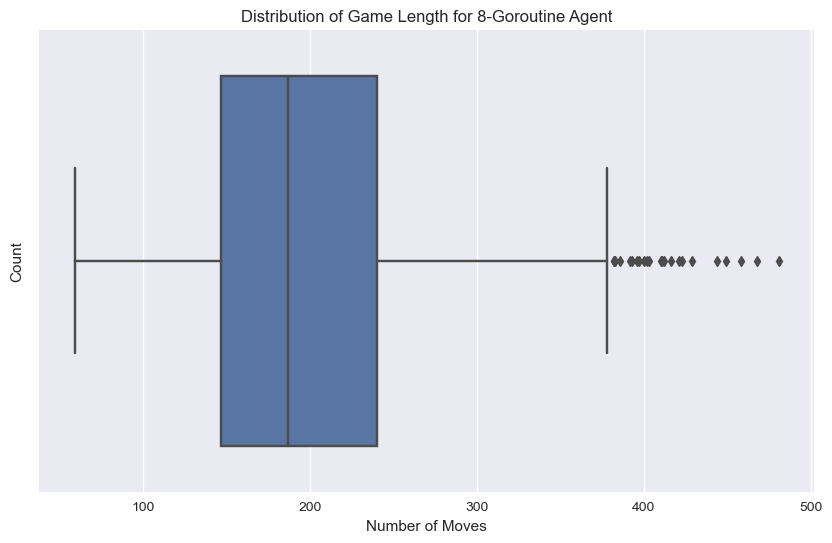

Game Length Distribution Statistics:
Lower Fence (Q1 - 1.5*IQR): 8
Lower Quartile (Q1): 147
Median (Q2): 187
Upper Quartile (Q3): 240


In [99]:
# DONE: plot distribution of game length (total number of moves) vs baseline sequential agent: histogram, box plot, violin plot
goroutine8_id = agent_configs[agent_configs['goroutines'] == 8]['id'].iloc[0]
goroutine8_games = game_records[game_records['agent2'] == goroutine8_id]

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=goroutine8_games, x='total_moves', kde=True)

# Add labels and title
plt.title('Distribution of Game Length for 8-Goroutine Agent')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')

# Save plot
plt.savefig(f"{output_dir}/game_length_histogram_8goroutine.png")
plt.show()

# DONE: find game length quartiles
# Calculate quartiles
Q1 = goroutine8_games['total_moves'].quantile(0.25)
Q2 = goroutine8_games['total_moves'].quantile(0.50)  # median
Q3 = goroutine8_games['total_moves'].quantile(0.75)

# Create box plot of game length
plt.figure(figsize=(10, 6))
sns.boxplot(data=goroutine8_games, x='total_moves')

plt.title('Distribution of Game Length for 8-Goroutine Agent')
plt.xlabel('Number of Moves')
plt.ylabel('Count')

plt.savefig(f"{output_dir}/game_length_boxplot_8goroutine.png")
plt.show()

# Calculate IQR and lower fence for statistics
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR

print(f"Game Length Distribution Statistics:")
print(f"Lower Fence (Q1 - 1.5*IQR): {lower_fence:.0f}")
print(f"Lower Quartile (Q1): {Q1:.0f}")
print(f"Median (Q2): {Q2:.0f}")
print(f"Upper Quartile (Q3): {Q3:.0f}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


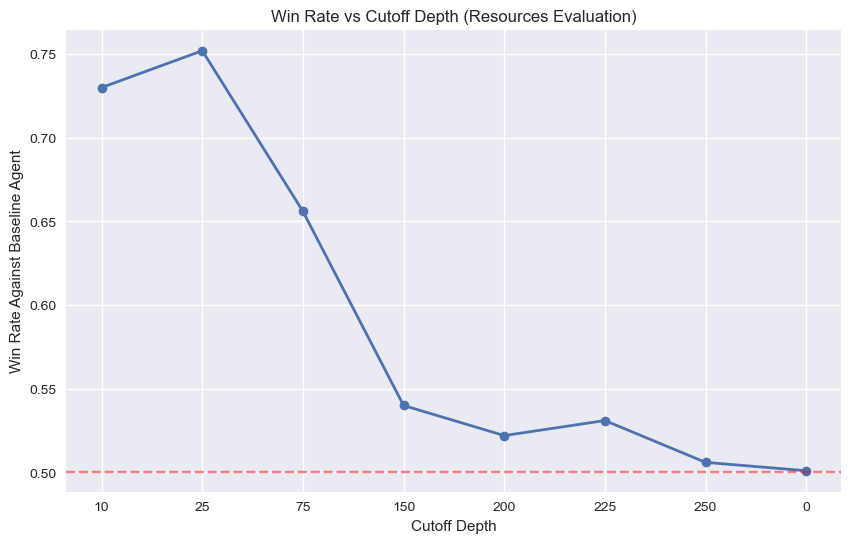

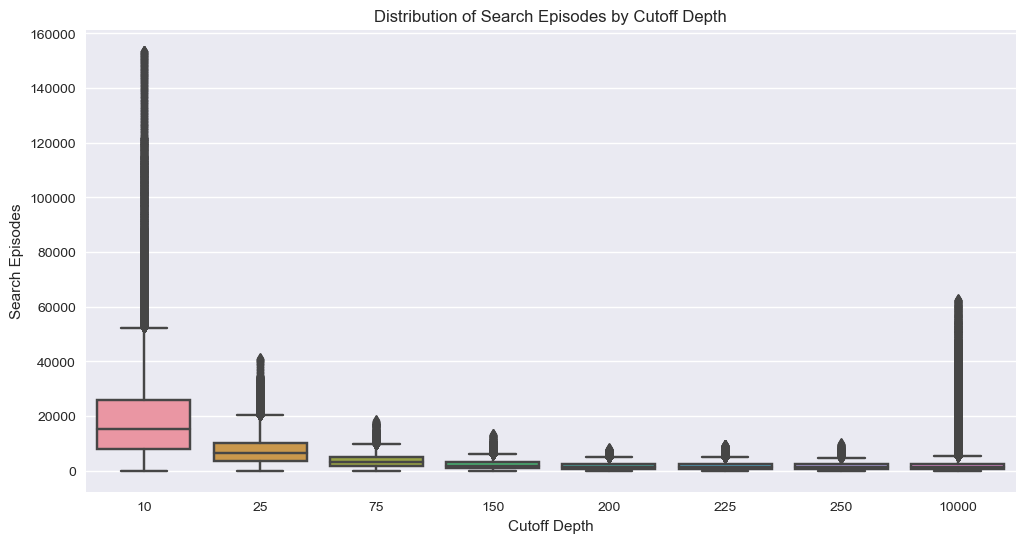

In [100]:

# experiment setup: pick 1 parallel agent (e.g. 16-goroutine, full playout) as new baseline, vary cutoff depth {10 or lower fence, lower quartile, median, upper quartile, full playout} while keeping other parameters constant (5 matchups), compare win rate and Elo rating 
# hypothesis: lower cutoff depth -> faster playouts -> more episodes (fixed time budget) -> discover more possible paths -> more robust stats -> more skilled agent -> higher win rate ASSUMING evaluation function estimates outcome well
# explanations: random full playout does not closely emulate real/intelligent game plays, good evaluation function may provide better outcome estimates, while faster rollouts allow more episodes within the same time budget
# future work: findings/lessons learned here (to improve playing strength) transferrable to other agents (other currency levels, after tailoring cutoff depth according to its game length distribution)
# optional: each/best agent in the cutoff depth experiment group plays 100 games against the sequential baseline, compare difference in win rates via statistical tests? (no added value)
# *ANOVA* determines whether *3 or more groups'* means are statistically significantly different/unequal (N/A). *t-test* determines whether *2 groups'* means OR *1 group's mean vs a fixed value* are statistically significantly different/larger/smaller (N/A).

# DONE: calculate and plot experiment agents' win rates
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/cutoff")

cutoff_win_rates = calculate_win_rates(game_records, agent_configs)
# cutoff_win_rates = process_cutoff_labels(cutoff_win_rates)
plt = plot_win_rates(
    cutoff_win_rates,
    param_col="cutoff", 
    output_dir=output_dir,
    title="Win Rate vs Cutoff Depth (Resources Evaluation)",
    xlabel="Cutoff Depth"
)
plt.show()

show_missing_data(game_records)

# DONE: calculate and plot experiment agents' throughput distribution (episodes/time budget) in the same format as concurrency experiment
plt = plot_episodes_by_cutoff(move_records, agent_configs, output_dir)
plt.show()

# TODO: potentially 1) calculate the correlation coefficient 2) show the correlation (2 lines in one chart) between throughput and win rate

# 3. evaluation function ~ outcome estimate quality ~ playing strength (win rate, Elo?)
 

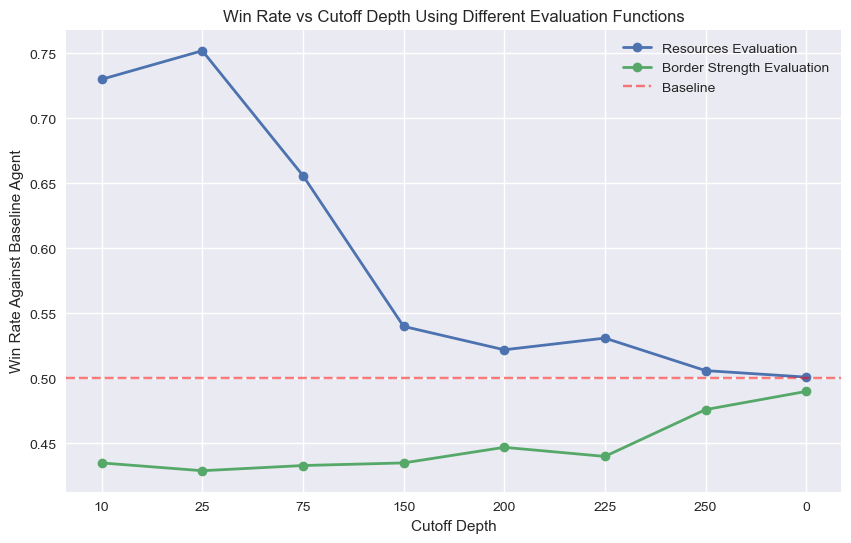

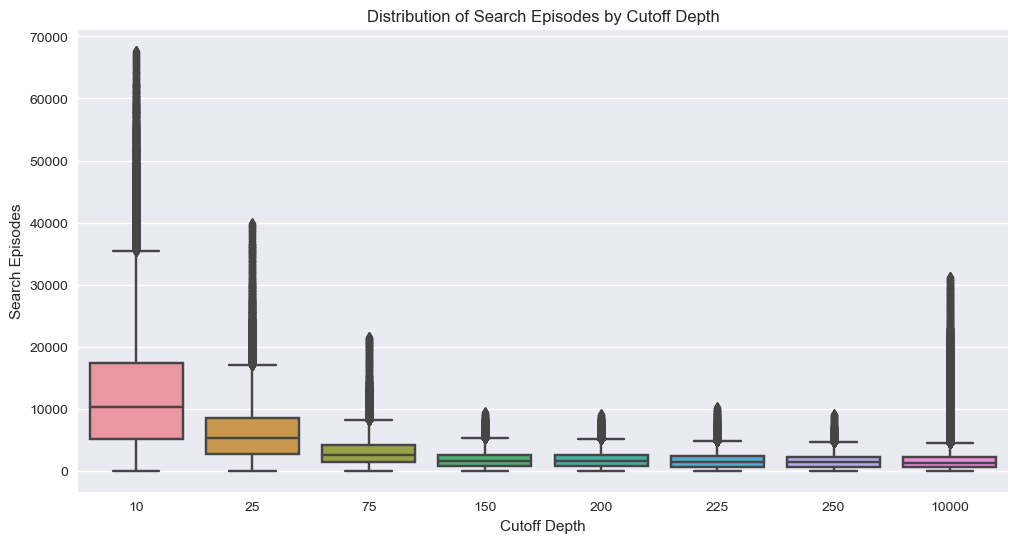

In [101]:
# DONE: same setup as cutoff experiment, but each experiment group agent uses border strength evaluation
# DONE: plot another line in win rate chart (5 matchups)
# hypothesis: border strength evaluation estimates outcome more accurately than resources evaluation > higher win rate at each agent > the effect may be bigger when cutoff depth is smaller 
# TODO: same setup could be extened with an agent that uses value network predictions as evaluation result to evaluate value network (future work)

agent_configs, game_records, move_records, output_dir = load_experiment_data("data/evaluation")

show_missing_data(game_records)

eval_win_rates = calculate_win_rates(game_records, agent_configs)
# eval_win_rates = process_cutoff_labels(eval_win_rates)
plt = plot_combined_win_rates(
    [(cutoff_win_rates, "Resources Evaluation"), 
     (eval_win_rates, "Border Strength Evaluation")],
    param_col="cutoff",
    output_dir=output_dir,
    title="Win Rate vs Cutoff Depth Using Different Evaluation Functions",
    xlabel="Cutoff Depth"
)
plt.show()

# DONE: plot throughput distribution for evaluation experiment agents
plt = plot_episodes_by_cutoff(move_records, agent_configs, output_dir)
plt.show()

# TODO: fix/improve border strength evaluation function (should have higher win rates)


# 4. corroborate findings > Elo ratings
setup:
- agents: 1) sequential agent, 2) 8-goroutine agent (full playout), 3) parallel agent + cutoff (resources evaluation), 4) parallel agent + cutoff + border strength evaluation
- **round-robin** 30 games between each pair (5 matchups), alternating start, random board initialization
- update Elo ratings with game outcomes in **random** order till **convergence** > relative playing strength (should show upwards trend)

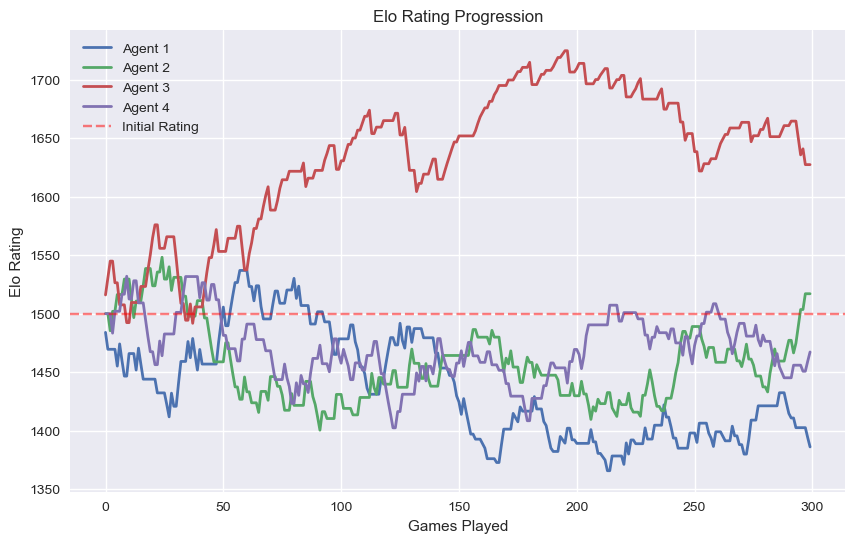

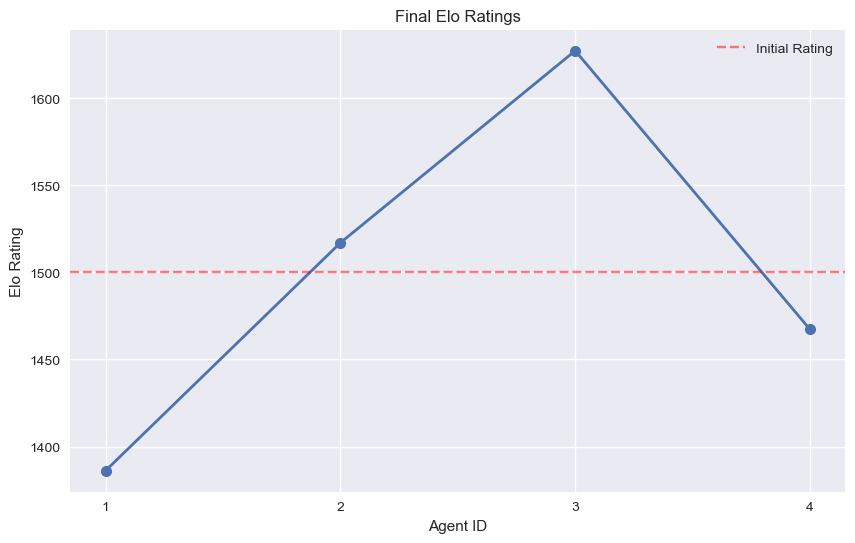

In [102]:
# TODO: calculate Elo rating updates
# TODO: plot Elo rating updatse over time, show final ratings after convergence

# TODO: establish and implement a convergence criterion 

agent_configs, game_records, move_records, output_dir = load_experiment_data("data/elo")

# TODO: apply diff K values depending on # of games each pair
# TODO: optional seed for reproducibility

# Calculate Elo ratings after each game
ratings_df = calculate_elo_updates(game_records, seed=None)

# Plot ratings progression
# TODO: check convergence
plt = plot_elo_progression(ratings_df, agent_configs, output_dir)
plt.show()

# Plot final ratings
plt = plot_final_elo_ratings(ratings_df.iloc[-1], agent_configs, output_dir)
plt.show()

- ratings should converge
- should show upwards trend across agents

Agent 1 vs Agent 2: 21 wins out of 50 games
Agent 1 vs Agent 3: 11 wins out of 50 games
Agent 1 vs Agent 4: 23 wins out of 50 games
Agent 2 vs Agent 1: 29 wins out of 50 games
Agent 2 vs Agent 3: 12 wins out of 50 games
Agent 2 vs Agent 4: 25 wins out of 50 games
Agent 3 vs Agent 1: 39 wins out of 50 games
Agent 3 vs Agent 2: 38 wins out of 50 games
Agent 3 vs Agent 4: 36 wins out of 50 games
Agent 4 vs Agent 1: 27 wins out of 50 games
Agent 4 vs Agent 2: 25 wins out of 50 games
Agent 4 vs Agent 3: 14 wins out of 50 games


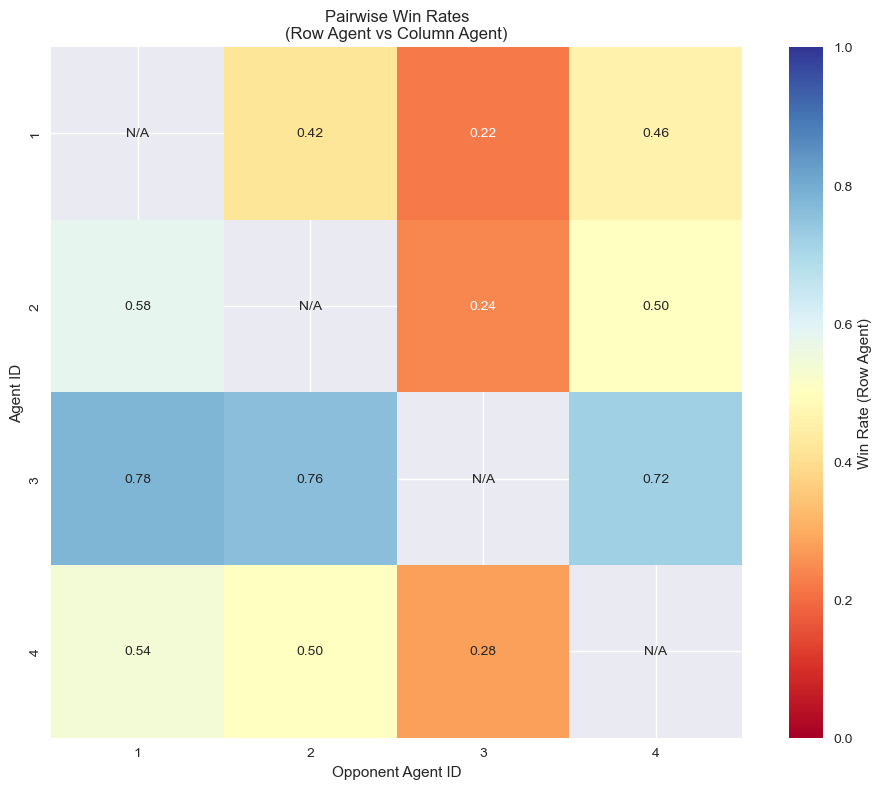

,id,agent1,agent2,starting_player,winner,start_time,end_time,duration,total_moves


In [103]:
# Calculate pairwise win rates
win_rates = calculate_pairwise_win_rates(game_records, agent_configs)

# Plot win rate heatmap
plt = plot_win_rate_heatmap(win_rates, agent_configs, output_dir)
plt.show()

show_missing_data(game_records)
